In [1]:
import os
import glob
import json
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE=32
HEIGHT=360
WIDTH=360

In [3]:
train_df = pd.DataFrame(columns=['directory','label'])

In [4]:
for i in os.listdir('../input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients'):
    for j in os.listdir('../input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients'+'/'+i+'/'):
        train_df = train_df.append({'directory':'../input/nutrientdeficiencysymptomsinrice/rice_plant_lacks_nutrients'+'/'+i+'/'+j,'label':i},ignore_index=True)

In [5]:
for i in os.listdir('../input/rice-disease/Data-image'):
    for j in os.listdir('../input/rice-disease/Data-image'+'/'+i+'/'):
        train_df = train_df.append({'directory':'../input/rice-disease/Data-image'+'/'+i+'/'+j,'label':i},ignore_index=True)

In [6]:
for i in os.listdir('../input/rice-diseases-image-dataset/LabelledRice/Labelled'):
    for j in os.listdir('../input/rice-diseases-image-dataset/LabelledRice/Labelled'+'/'+i+'/'):
        train_df = train_df.append({'directory':'../input/rice-diseases-image-dataset/LabelledRice/Labelled'+'/'+i+'/'+j,'label':i},ignore_index=True)

In [7]:
for i in os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases'):
    for j in os.listdir('../input/rice-leaf-diseases/rice_leaf_diseases'+'/'+i+'/'):
        train_df = train_df.append({'directory':'../input/rice-leaf-diseases/rice_leaf_diseases'+'/'+i+'/'+j,'label':i},ignore_index=True)

In [8]:
train_df.shape

(7131, 2)

In [9]:
train_df

,directory,label
0,../input/nutrientdeficiencysymptomsinrice/rice...,Potassium(K)
1,../input/nutrientdeficiencysymptomsinrice/rice...,Potassium(K)
2,../input/nutrientdeficiencysymptomsinrice/rice...,Potassium(K)
3,../input/nutrientdeficiencysymptomsinrice/rice...,Potassium(K)
4,../input/nutrientdeficiencysymptomsinrice/rice...,Potassium(K)
...,...,...
7126,../input/rice-leaf-diseases/rice_leaf_diseases...,Leaf smut
7127,../input/rice-leaf-diseases/rice_leaf_diseases...,Leaf smut
7128,../input/rice-leaf-diseases/rice_leaf_diseases...,Leaf smut
7129,../input/rice-leaf-diseases/rice_leaf_diseases...,Leaf smut


In [10]:
train_df.replace({'leaf_blast': 'LeafBlast', 'Brown spot': 'BrownSpot'},inplace=True)

In [11]:
dic={}
for i in range(len(train_df.label.unique())):
    dic[train_df.label.unique()[i]] = np.float16(i)
key_list = list(dic.keys())
val_list = list(dic.values())
train_df.replace(dic,inplace=True)
train_df

,directory,label
0,../input/nutrientdeficiencysymptomsinrice/rice...,0.0
1,../input/nutrientdeficiencysymptomsinrice/rice...,0.0
2,../input/nutrientdeficiencysymptomsinrice/rice...,0.0
3,../input/nutrientdeficiencysymptomsinrice/rice...,0.0
4,../input/nutrientdeficiencysymptomsinrice/rice...,0.0
...,...,...
7126,../input/rice-leaf-diseases/rice_leaf_diseases...,12.0
7127,../input/rice-leaf-diseases/rice_leaf_diseases...,12.0
7128,../input/rice-leaf-diseases/rice_leaf_diseases...,12.0
7129,../input/rice-leaf-diseases/rice_leaf_diseases...,12.0


In [12]:
X= train_df['directory']
y= train_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,shuffle=True)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(5348,) (5348,) (1783,) (1783,)


In [13]:
def load_images(files):
    images=[]
    for i in files:
        a = Image.open(i)
        a = a.resize((HEIGHT,WIDTH))
        a = np.asarray(a)
#         a = a/255.0
        images.append(a)
    return np.array(images)

In [14]:
def DataGen(data,label,bsize=BATCH_SIZE):
    while True:
        for i in range(len(data)):
#             rand = np.random.randint(0,len(data)-BATCH_SIZE)
            images = load_images(data[i:i+BATCH_SIZE])
            labels = label[i:i+BATCH_SIZE]
            yield np.array(images),np.array(labels)

In [15]:
train_dataset = DataGen(X_train,y_train)
valid_dataset = DataGen(X_test,y_test)
a,b = next(train_dataset)
c,d = next(valid_dataset)
print(a.shape,b.shape,c.shape,d.shape)

(32, 360, 360, 3) (32,) (32, 360, 360, 3) (32,)


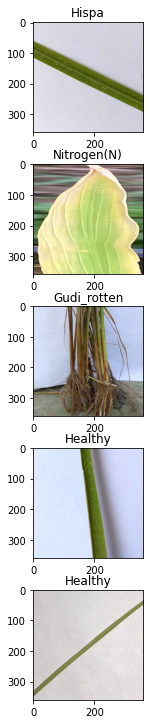

In [16]:
def sample_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        
        axs[i].imshow(image[i])
        axs[i].set_title(key_list[val_list.index(label[i])])
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
sample_plot(a,b)

In [17]:
inputs = tf.keras.layers.Input((HEIGHT,WIDTH,3))
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])(inputs)
    
base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet',pooling='max')
base_model.trainable=True
x = base_model(data_augmentation,training=True)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(dic), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])#,tf.keras.metrics.AUC()])

2021-10-19 15:00:54.630831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 15:00:54.724036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 15:00:54.724825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-19 15:00:54.726610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 360, 360, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
_________________________________________________________________
dense_1 (Dense)              (None, 13)                221       
Total params: 6,595,956
Trainable params: 6,533,901
Non-trainable params: 62,055
______________________________________________

In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('baseline_model.hdf5', monitor='val_sparse_categorical_crossentropy', verbose=1, save_best_only=True, mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',patience=3,verbose=1,factor=0.5,min_lr=1e-5)
TRAIN_STEPS = 100
VAL_STEPS = 25
EPOCHS = 5
history = model.fit(train_dataset, steps_per_epoch=TRAIN_STEPS,validation_data=(valid_dataset),validation_steps=VAL_STEPS,
                    batch_size=BATCH_SIZE,epochs=EPOCHS, callbacks = checkpoint)

2021-10-19 15:01:05.934050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-10-19 15:01:17.804348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 580s 6s/step - loss: 1.3367 - sparse_categorical_accuracy: 0.5469 - val_loss: 1.7365 - val_sparse_categorical_accuracy: 0.6737
Epoch 2/5
100/100 [==============================] - 566s 6s/step - loss: 0.4266 - sparse_categorical_accuracy: 0.8706 - val_loss: 2.2680 - val_sparse_categorical_accuracy: 0.5825
Epoch 3/5
100/100 [==============================] - 569s 6s/step - loss: 0.2131 - sparse_categorical_accuracy: 0.9375 - val_loss: 1.7384 - val_sparse_categorical_accuracy: 0.5437
Epoch 4/5
100/100 [==============================] - 602s 6s/step - loss: 0.2415 - sparse_categorical_accuracy: 0.9350 - val_loss: 1.9095 - val_sparse_categorical_accuracy: 0.7312
Epoch 5/5
100/100 [==============================] - 598s 6s/step - loss: 0.2391 - sparse_categorical_accuracy: 0.9419 - val_loss: 2.2569 - val_sparse_categorical_accuracy: 0.7713


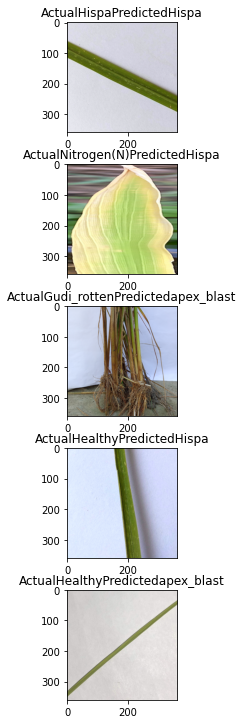

In [20]:
def test_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        y_pred = model.predict(np.reshape(image[i],(1,HEIGHT,WIDTH,3)))
        y_pred_l = np.argmax(y_pred)
        
#         y_pred_l= 'Real' if y_pred==0.0 else 'Fake'
#         y_true_l = 'Real' if label[i]==0.0 else 'Fake'
        axs[i].imshow(image[i])
        axs[i].set_title('Actual'+str(key_list[val_list.index(label[i])])+'Predicted'+key_list[val_list.index(y_pred_l)])
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
test_plot(a,b)

In [21]:
model.save('baseline_final.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
